# Arabic Dialect Identification Token-Level version 3

In [ ]:
import torch
torch.cuda.set_device(1)   # OK to keep
device = torch.device("cuda:0")

## Token-Level Classification Only

✅ Arabic shaping enabled.
📥 Loading 'arbml/AOC_ALDi' from HF …


Repo card metadata block was not found. Setting CardData to empty.


✅ Built pools from HF AOC_ALDi.
Pool sizes: {'msa': 63889, 'egyptian': 9987, 'levantine': 11025, 'gulf': 11984, 'maghrebi': 167}
✅ Built 1500 mixed mixed-dialect examples.
🚀 Training...

🌟 Epoch 1/4


/home/aattiah/Arabic_Dialects/venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


🟡 Epoch 1/4 | Step 20/188 | Loss 1.5786
🟡 Epoch 1/4 | Step 40/188 | Loss 1.5963
🟡 Epoch 1/4 | Step 60/188 | Loss 1.5117
🟡 Epoch 1/4 | Step 80/188 | Loss 1.1728
🟡 Epoch 1/4 | Step 100/188 | Loss 1.2286
🟡 Epoch 1/4 | Step 120/188 | Loss 1.3667
🟡 Epoch 1/4 | Step 140/188 | Loss 1.1656
🟡 Epoch 1/4 | Step 160/188 | Loss 1.1097
🟡 Epoch 1/4 | Step 180/188 | Loss 1.1491
🟡 Epoch 1/4 | Step 188/188 | Loss 0.8075
✅ Epoch 1 avg loss: 1.2916

🌟 Epoch 2/4
🟡 Epoch 2/4 | Step 20/188 | Loss 0.7768
🟡 Epoch 2/4 | Step 40/188 | Loss 0.7233
🟡 Epoch 2/4 | Step 60/188 | Loss 0.7027
🟡 Epoch 2/4 | Step 80/188 | Loss 0.6141
🟡 Epoch 2/4 | Step 100/188 | Loss 0.5760
🟡 Epoch 2/4 | Step 120/188 | Loss 0.8201
🟡 Epoch 2/4 | Step 140/188 | Loss 1.0332
🟡 Epoch 2/4 | Step 160/188 | Loss 0.5807
🟡 Epoch 2/4 | Step 180/188 | Loss 0.6899
🟡 Epoch 2/4 | Step 188/188 | Loss 0.3777
✅ Epoch 2 avg loss: 0.7073

🌟 Epoch 3/4
🟡 Epoch 3/4 | Step 20/188 | Loss 0.4833
🟡 Epoch 3/4 | Step 40/188 | Loss 0.4615
🟡 Epoch 3/4 | Step 60/188 | 

/home/aattiah/Arabic_Dialects/venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/aattiah/Arabic_Dialects/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


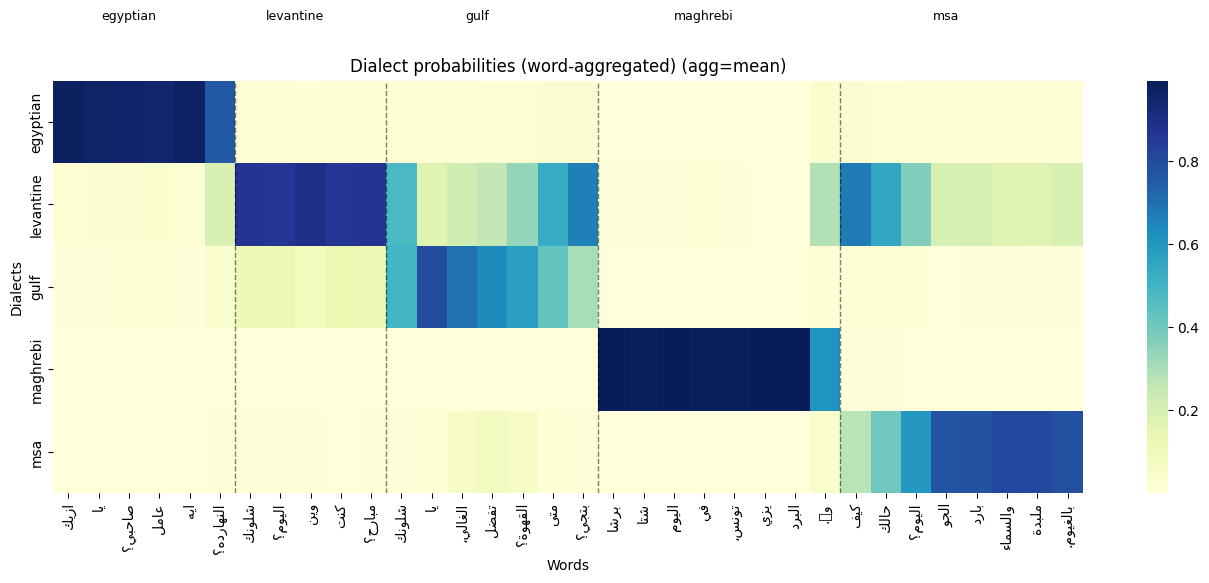

In [2]:
# ========================= TOKEN WORD-LEVEL TRAIN + HEATMAP (END-TO-END) =========================
# Works with: transformers, datasets, torch, seaborn, matplotlib.
# Optional (for nicer Arabic labels): pip install arabic-reshaper python-bidi

import os, re, ast, random, numpy as np, torch, torch.nn as nn
import matplotlib as mpl, matplotlib.pyplot as plt, seaborn as sns
from collections import defaultdict, Counter
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup

# ----------------------- Config -----------------------
config = {
    "base_model": "UBC-NLP/MARBERT",
    "num_labels": 5,
    "max_length": 256,
    "batch_size": 8,
    "epochs": 4,
    "lr_bert": 2e-5,
    "lr_head": 1e-4,
    "weight_decay": 0.01,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
}
LABELS = ["egyptian","levantine","gulf","maghrebi","msa"]
D2I = {n:i for i,n in enumerate(LABELS)}
random.seed(config["seed"]); np.random.seed(config["seed"]); torch.manual_seed(config["seed"])

# ---------------- Arabic shaping for plots (optional) -------------
mpl.rcParams["font.family"] = "DejaVu Sans"
try:
    import arabic_reshaper
    from bidi.algorithm import get_display
    def shape_ar(s): return get_display(arabic_reshaper.reshape(s))
    print("✅ Arabic shaping enabled.")
except Exception:
    def shape_ar(s): return s
    print("ℹ️ Tip: pip install arabic-reshaper python-bidi for perfect Arabic tick labels.")

# ================== 1) BUILD DIALECT POOLS (robust) ==================
def _parse_dialect_field(d):
    if isinstance(d, list): return d
    if isinstance(d, str):
        s = d.strip()
        if s.startswith("[") and s.endswith("]"):
            try:
                lst = ast.literal_eval(s)
                if isinstance(lst, list): return lst
            except Exception: pass
        return [s]
    return []

def _get_text(row):
    return (row.get("sentence") or row.get("text") or "").strip()

def load_pools_from_any():
    """
    Returns: dict {dialect: [sentence, ...]}
    Tries in-RAM datasets if present; else falls back to HF AOC_ALDi; else tiny manual seeds.
    """
    pools = defaultdict(list)

    # 1) Try in-RAM variables you may already have in this notebook
    for ds_name in ["balanced_dataset", "processed_dataset", "dataset", "raw_dataset"]:
        if ds_name in globals():
            ds = globals()[ds_name]
            for row in ds:
                txt = _get_text(row)
                if not txt or len(txt.split()) < 3: continue
                di_raw = row.get("main_dialect", None) or row.get("dialect", None)
                choices = _parse_dialect_field(di_raw)
                pick = next((x for x in choices if x in D2I), None)
                if pick in D2I: pools[pick].append(re.sub(r"\s+", " ", txt))
            if any(len(v) for v in pools.values()):
                print(f"✅ Built pools from in-RAM '{ds_name}'.")
                return pools

    # 2) Try Hugging Face AOC_ALDi
    try:
        from datasets import load_dataset
        print("📥 Loading 'arbml/AOC_ALDi' from HF …")
        ds = load_dataset("arbml/AOC_ALDi", split="train")
        for row in ds:
            txt = _get_text(row)
            if not txt or len(txt.split()) < 3: continue
            choices = _parse_dialect_field(row.get("dialect"))
            pick = next((x for x in choices if x in D2I), None)
            if pick in D2I: pools[pick].append(re.sub(r"\s+", " ", txt))
        if any(len(v) for v in pools.values()):
            print("✅ Built pools from HF AOC_ALDi.")
            return pools
        else:
            print("⚠️ HF dataset had no usable rows (unexpected).")
    except Exception as e:
        print("⚠️ Could not load from HF:", e)

    # 3) Tiny manual fallback so you can run end-to-end right now
    print("⚠️ Falling back to tiny manual seed pools (demo only).")
    pools["egyptian"] = [
        "ازيك يا صاحبي؟ عامل ايه النهارده؟",
        "الجو حر النهارده، مش كده؟",
    ]
    pools["levantine"] = [
        "شلونك اليوم؟ وين كنت مبارح؟",
        "شو رأيك نطلع نتعشى بره الليلة؟",
    ]
    pools["gulf"] = [
        "شلونك يا الغالي، تفضل القهوة؟ متى بتجي؟",
        "اليوم الجو حار في الرياض.",
    ]
    pools["maghrebi"] = [
        "برشا شتا اليوم في تونس، يزّي البرد والله.",
        "شنو حوالك؟ كل شي بخير؟",
    ]
    pools["msa"] = [
        "كيف حالك اليوم؟ الجو بارد والسماء ملبدة بالغيوم.",
        "ذهب الطالب إلى الجامعة في الصباح الباكر.",
    ]
    return pools

pools = load_pools_from_any()
print("Pool sizes:", {k: len(v) for k,v in pools.items()})

# ============== 2) BUILD MIXED EXAMPLES (word-labeled) ==============
def build_mixed_examples(pools, n_docs=1500, seg_len_words=5, n_segments=4):
    """
    Create synthetic mixed 'sentences' by concatenating short segments
    from different dialect pools. Produces per-word dialect labels.
    """
    rows = []
    label_names = [n for n in LABELS if len(pools.get(n, [])) > 0]
    if len(label_names) < 2:
        raise RuntimeError("Need at least 2 dialect pools with data to build mixed examples.")
    for _ in range(n_docs):
        chosen = random.sample(label_names, k=min(n_segments, len(label_names)))
        words, word_dialects = [], []
        for d in chosen:
            sent = random.choice(pools[d])
            seg = sent.split()[:seg_len_words]
            if not seg: continue
            words.extend(seg)
            word_dialects.extend([d]*len(seg))
        if len(words) >= 6:
            rows.append({"words": words, "word_dialects": word_dialects})
    return rows

mixed_rows = build_mixed_examples(pools, n_docs=1500, seg_len_words=5, n_segments=4)
print(f"✅ Built {len(mixed_rows)} mixed mixed-dialect examples.")

# ============== 3) DATASET → TOKEN IDs WITH WORD ALIGNMENT ==========
class TokenDataset(Dataset):
    def __init__(self, rows, tokenizer, max_len):
        self.rows = rows; self.tok = tokenizer; self.max_len = max_len
    def __len__(self): return len(self.rows)
    def __getitem__(self, idx):
        r = self.rows[idx]
        words = r["words"]; labs = r["word_dialects"]
        enc = self.tok(words, is_split_into_words=True, truncation=True,
                       padding="max_length", max_length=self.max_len, return_tensors="pt")
        input_ids = enc["input_ids"].squeeze(0)
        attn      = enc["attention_mask"].squeeze(0)
        word_ids  = enc.word_ids(0)
        labels = [-100]*len(word_ids)
        for i, w in enumerate(word_ids):
            if w is None: continue
            d = labs[w] if 0 <= w < len(labs) else None
            labels[i] = D2I.get(d, -100)
        return {"input_ids": input_ids, "attention_mask": attn, "labels": torch.tensor(labels, dtype=torch.long)}

def collate(batch):
    return {k: torch.stack([b[k] for b in batch]) for k in ["input_ids","attention_mask","labels"]}

tokenizer = AutoTokenizer.from_pretrained(config["base_model"])
train_set = TokenDataset(mixed_rows, tokenizer, config["max_length"])
train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True, collate_fn=collate)

# ============== 4) MODEL (token multiclass CE) ======================
class BertForTokenDialect(nn.Module):
    def __init__(self, base_model, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(base_model)
        H = self.bert.config.hidden_size
        self.classifier = nn.Linear(H, num_labels)
        self.config = self.bert.config
        self.config.id2label = {i:n for i,n in enumerate(LABELS)}
        self.config.label2id = {n:i for i,n in enumerate(LABELS)}
    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.classifier(out.last_hidden_state)  # (B,L,C)
        return logits

model = BertForTokenDialect(config["base_model"], config["num_labels"]).to(config["device"])

# Class weights from generated rows (reduces one-class bias)
def estimate_class_weights(rows):
    cnt = Counter()
    for r in rows: cnt.update(r["word_dialects"])
    tot = sum(cnt.get(n,0) for n in LABELS)
    w = []
    for n in LABELS:
        c = cnt.get(n,1)
        w.append(tot/(len(LABELS)*c))
    return torch.tensor(w, dtype=torch.float)

class_weights = estimate_class_weights(mixed_rows).to(config["device"])
loss_fn = nn.CrossEntropyLoss(weight=class_weights, ignore_index=-100)

# Optimizer with higher LR for the head + scheduler
opt = torch.optim.AdamW([
    {"params": model.bert.parameters(), "lr": config["lr_bert"]},
    {"params": model.classifier.parameters(), "lr": config["lr_head"]},
], weight_decay=config["weight_decay"])

total_steps = config["epochs"] * len(train_loader)
sched = get_linear_schedule_with_warmup(
    opt, num_warmup_steps=max(50, int(0.05*total_steps)), num_training_steps=total_steps
)

# ============== 5) TRAIN ===============================
print("🚀 Training...")
for ep in range(1, config["epochs"]+1):
    model.train(); running = 0.0
    print(f"\n🌟 Epoch {ep}/{config['epochs']}")
    for step, batch in enumerate(train_loader, start=1):
        input_ids = batch["input_ids"].to(config["device"])
        attn      = batch["attention_mask"].to(config["device"])
        labels    = batch["labels"].to(config["device"])

        logits = model(input_ids, attn)                       # (B,L,C)
        loss = loss_fn(logits.view(-1, config["num_labels"]), labels.view(-1))

        opt.zero_grad(); loss.backward(); opt.step(); sched.step()
        running += loss.item()
        if step % 20 == 0 or step == len(train_loader):
            print(f"🟡 Epoch {ep}/{config['epochs']} | Step {step}/{len(train_loader)} | Loss {loss.item():.4f}")
    print(f"✅ Epoch {ep} avg loss: {running/len(train_loader):.4f}")

# Save checkpoint
ckpt_path = "marbert_token_model_mixed.pt"
torch.save(model.state_dict(), ckpt_path)
print(f"💾 Saved to {ckpt_path}")

# ============== 6) WORD-LEVEL HEATMAP (inference) ==============
def word_heatmap(sentences, model, tokenizer, max_length=256, agg="mean", title="Dialect probabilities"):
    """
    sentences: list of (dialect_tag, text) or list of strings.
    Aggregates subword probs -> word probs via 'mean' or 'max'. Plots heatmap + prints stats.
    """
    model.eval()
    if isinstance(sentences[0], tuple):
        texts = [t for _, t in sentences]
        tags  = [d for d, _ in sentences]
    else:
        texts = sentences; tags = [""]*len(texts)

    sent_words = [re.findall(r'\S+', s) for s in texts]
    words = [w for lst in sent_words for w in lst]
    bounds = np.cumsum([len(lst) for lst in sent_words]).tolist()[:-1]

    enc = tokenizer(words, is_split_into_words=True, truncation=True,
                    max_length=max_length, return_tensors="pt")
    input_ids = enc["input_ids"].to(config["device"])
    attn      = enc["attention_mask"].to(config["device"])
    wids      = enc.word_ids(0)

    with torch.no_grad():
        logits = model(input_ids, attn)[0]              # (L,C)
        probs_tok = torch.softmax(logits, dim=-1).cpu().numpy()

    # subword -> word
    W, C = len(words), len(LABELS)
    word_probs = np.zeros((W, C), dtype=np.float32)
    if agg == "max":
        word_probs[:] = -1e9
    else:
        counts = np.zeros(W, dtype=np.int32)

    for t, w in enumerate(wids):
        if w is None: continue
        if agg == "max":
            word_probs[w] = np.maximum(word_probs[w], probs_tok[t])
        else:
            word_probs[w] += probs_tok[t]; counts[w] += 1

    if agg == "max":
        word_probs[word_probs < -1e8] = 0.0
    else:
        counts = np.maximum(counts, 1); word_probs = word_probs / counts[:, None]

    # stats
    top = word_probs.argmax(1)
    pred_labels = [LABELS[i] for i in top]
    cnt = Counter(pred_labels); total = len(pred_labels)
    print("\n🧮 Word Dialect Stats:")
    for n in LABELS:
        k = cnt.get(n,0); print(f"- {n:<9}: {k:4d} words ({(100*k/total if total else 0):5.1f}%)")
    print("\n🔎 Mean prob:")
    m = word_probs.mean(0)
    for i,n in enumerate(LABELS): print(f"  {n:<9}: {m[i]:.3f}")

    # plot
    xlabels = [shape_ar(w) for w in words]
    plt.figure(figsize=(min(24, max(12, len(words)*0.4)), 6))
    ax = sns.heatmap(word_probs.T, xticklabels=xlabels, yticklabels=LABELS, cmap="YlGnBu")
    plt.title(f"{title} (agg={agg})"); plt.xlabel("Words"); plt.ylabel("Dialects")
    for idx in bounds:
        ax.axvline(idx, color='k', linewidth=1, linestyle='--', alpha=0.5)
    # annotate intended tags (if provided)
    start = 0
    for tag, end in zip(tags, bounds + [len(words)]):
        if tag:
            mid = (start + end - 1)/2.0
            ax.text(mid, -0.7, tag, ha='center', va='bottom', fontsize=9)
        start = end
    plt.tight_layout(); plt.show()

# ====== Demo doc with separated dialect sentences ======
demo = [
    ("egyptian",  "ازيك يا صاحبي؟ عامل ايه النهارده؟"),
    ("levantine", "شلونك اليوم؟ وين كنت مبارح؟"),
    ("gulf",      "شلونك يا الغالي، تفضل القهوة؟ متى بتجي؟"),
    ("maghrebi",  "برشا شتا اليوم في تونس، يزّي البرد والله."),
    ("msa",       "كيف حالك اليوم؟ الجو بارد والسماء ملبدة بالغيوم."),
]
word_heatmap(demo, model, tokenizer, max_length=config["max_length"], agg="mean",
             title="Dialect probabilities (word-aggregated)")
# =========================================================================================


## Token-Level with Classification and Regression

✅ Arabic shaping enabled.
📥 Loading 'arbml/AOC_ALDi' from HF …


Repo card metadata block was not found. Setting CardData to empty.


✅ Built pools from HF AOC_ALDi.
Pool sizes: {'msa': 63889, 'egyptian': 9987, 'levantine': 11025, 'gulf': 11984, 'maghrebi': 167}
✅ Built 1500 mixed mixed-dialect examples.
🚀 Training...

🌟 Epoch 1/4


/home/aattiah/Arabic_Dialects/venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


🟡 Epoch 1/4 | Step 20/188 | Loss 1.6979 | CE 1.5956 | REG 0.2047
🟡 Epoch 1/4 | Step 40/188 | Loss 1.6174 | CE 1.6016 | REG 0.0316
🟡 Epoch 1/4 | Step 60/188 | Loss 1.3515 | CE 1.3408 | REG 0.0215
🟡 Epoch 1/4 | Step 80/188 | Loss 1.3741 | CE 1.3633 | REG 0.0216
🟡 Epoch 1/4 | Step 100/188 | Loss 1.2801 | CE 1.2707 | REG 0.0188
🟡 Epoch 1/4 | Step 120/188 | Loss 0.9924 | CE 0.9822 | REG 0.0205
🟡 Epoch 1/4 | Step 140/188 | Loss 0.8196 | CE 0.8113 | REG 0.0165
🟡 Epoch 1/4 | Step 160/188 | Loss 0.9823 | CE 0.9738 | REG 0.0172
🟡 Epoch 1/4 | Step 180/188 | Loss 1.0658 | CE 1.0574 | REG 0.0166
🟡 Epoch 1/4 | Step 188/188 | Loss 0.7696 | CE 0.7624 | REG 0.0142
✅ Epoch 1 avg loss: 1.3357

🌟 Epoch 2/4
🟡 Epoch 2/4 | Step 20/188 | Loss 0.9085 | CE 0.9009 | REG 0.0151
🟡 Epoch 2/4 | Step 40/188 | Loss 0.7966 | CE 0.7883 | REG 0.0166
🟡 Epoch 2/4 | Step 60/188 | Loss 0.8020 | CE 0.7942 | REG 0.0156
🟡 Epoch 2/4 | Step 80/188 | Loss 0.6441 | CE 0.6368 | REG 0.0148
🟡 Epoch 2/4 | Step 100/188 | Loss 0.7041 | C

/home/aattiah/Arabic_Dialects/venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/aattiah/Arabic_Dialects/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


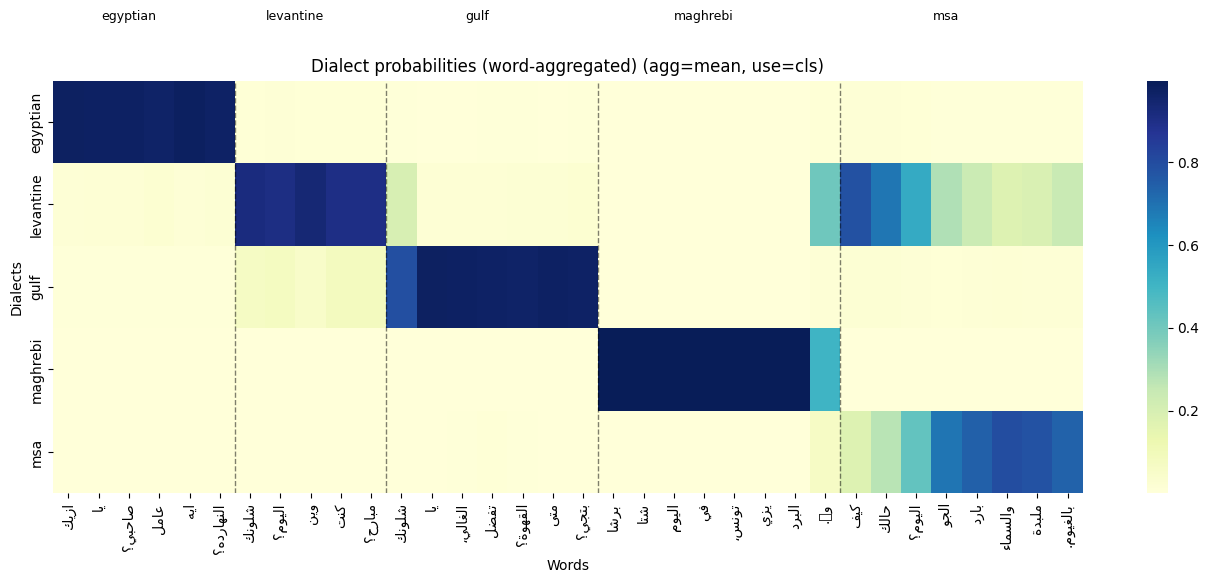

In [7]:
# ========================= TOKEN WORD-LEVEL TRAIN + HEATMAP (END-TO-END) =========================
# Works with: transformers, datasets, torch, seaborn, matplotlib.
# Optional (for nicer Arabic labels): pip install arabic-reshaper python-bidi

import os, re, ast, random, numpy as np, torch, torch.nn as nn
import matplotlib as mpl, matplotlib.pyplot as plt, seaborn as sns
from collections import defaultdict, Counter
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup

# ----------------------- Config -----------------------
config = {
    "base_model": "UBC-NLP/MARBERT",
    "num_labels": 5,
    "max_length": 256,
    "batch_size": 8,
    "epochs": 4,
    "lr_bert": 2e-5,
    "lr_head": 1e-4,
    "weight_decay": 0.01,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
}
LABELS = ["egyptian","levantine","gulf","maghrebi","msa"]
D2I = {n:i for i,n in enumerate(LABELS)}
random.seed(config["seed"]); np.random.seed(config["seed"]); torch.manual_seed(config["seed"])

# ---------------- Arabic shaping for plots (optional) -------------
mpl.rcParams["font.family"] = "DejaVu Sans"
try:
    import arabic_reshaper
    from bidi.algorithm import get_display
    def shape_ar(s): return get_display(arabic_reshaper.reshape(s))
    print("✅ Arabic shaping enabled.")
except Exception:
    def shape_ar(s): return s
    print("ℹ️ Tip: pip install arabic-reshaper python-bidi for perfect Arabic tick labels.")

# ================== 1) BUILD DIALECT POOLS (robust) ==================
def _parse_dialect_field(d):
    if isinstance(d, list): return d
    if isinstance(d, str):
        s = d.strip()
        if s.startswith("[") and s.endswith("]"):
            try:
                lst = ast.literal_eval(s)
                if isinstance(lst, list): return lst
            except Exception: pass
        return [s]
    return []

def _get_text(row):
    return (row.get("sentence") or row.get("text") or "").strip()

def load_pools_from_any():
    """
    Returns: dict {dialect: [sentence, ...]}
    Tries in-RAM datasets if present; else falls back to HF AOC_ALDi; else tiny manual seeds.
    """
    pools = defaultdict(list)

    # 1) Try in-RAM variables you may already have in this notebook
    for ds_name in ["balanced_dataset", "processed_dataset", "dataset", "raw_dataset"]:
        if ds_name in globals():
            ds = globals()[ds_name]
            for row in ds:
                txt = _get_text(row)
                if not txt or len(txt.split()) < 3: continue
                di_raw = row.get("main_dialect", None) or row.get("dialect", None)
                choices = _parse_dialect_field(di_raw)
                pick = next((x for x in choices if x in D2I), None)
                if pick in D2I: pools[pick].append(re.sub(r"\s+", " ", txt))
            if any(len(v) for v in pools.values()):
                print(f"✅ Built pools from in-RAM '{ds_name}'.")
                return pools

    # 2) Try Hugging Face AOC_ALDi
    try:
        from datasets import load_dataset
        print("📥 Loading 'arbml/AOC_ALDi' from HF …")
        ds = load_dataset("arbml/AOC_ALDi", split="train")
        for row in ds:
            txt = _get_text(row)
            if not txt or len(txt.split()) < 3: continue
            choices = _parse_dialect_field(row.get("dialect"))
            pick = next((x for x in choices if x in D2I), None)
            if pick in D2I: pools[pick].append(re.sub(r"\s+", " ", txt))
        if any(len(v) for v in pools.values()):
            print("✅ Built pools from HF AOC_ALDi.")
            return pools
        else:
            print("⚠️ HF dataset had no usable rows (unexpected).")
    except Exception as e:
        print("⚠️ Could not load from HF:", e)

    # 3) Tiny manual fallback so you can run end-to-end right now
    print("⚠️ Falling back to tiny manual seed pools (demo only).")
    pools["egyptian"] = [
        "ازيك يا صاحبي؟ عامل ايه النهارده؟",
        "الجو حر النهارده، مش كده؟",
    ]
    pools["levantine"] = [
        "شلونك اليوم؟ وين كنت مبارح؟",
        "شو رأيك نطلع نتعشى بره الليلة؟",
    ]
    pools["gulf"] = [
        "شلونك يا الغالي، تفضل القهوة؟ متى بتجي؟",
        "اليوم الجو حار في الرياض.",
    ]
    pools["maghrebi"] = [
        "برشا شتا اليوم في تونس، يزّي البرد والله.",
        "شنو حوالك؟ كل شي بخير؟",
    ]
    pools["msa"] = [
        "كيف حالك اليوم؟ الجو بارد والسماء ملبدة بالغيوم.",
        "ذهب الطالب إلى الجامعة في الصباح الباكر.",
    ]
    return pools

pools = load_pools_from_any()
print("Pool sizes:", {k: len(v) for k,v in pools.items()})

# ============== 2) BUILD MIXED EXAMPLES (word-labeled) ==============
def build_mixed_examples(pools, n_docs=1500, seg_len_words=5, n_segments=4):
    """
    Create synthetic mixed 'sentences' by concatenating short segments
    from different dialect pools. Produces per-word dialect labels.
    """
    rows = []
    label_names = [n for n in LABELS if len(pools.get(n, [])) > 0]
    if len(label_names) < 2:
        raise RuntimeError("Need at least 2 dialect pools with data to build mixed examples.")
    for _ in range(n_docs):
        chosen = random.sample(label_names, k=min(n_segments, len(label_names)))
        words, word_dialects = [], []
        for d in chosen:
            sent = random.choice(pools[d])
            seg = sent.split()[:seg_len_words]
            if not seg: continue
            words.extend(seg)
            word_dialects.extend([d]*len(seg))
        if len(words) >= 6:
            rows.append({"words": words, "word_dialects": word_dialects})
    return rows

mixed_rows = build_mixed_examples(pools, n_docs=1500, seg_len_words=5, n_segments=4)
print(f"✅ Built {len(mixed_rows)} mixed mixed-dialect examples.")

# ============== 3) DATASET → TOKEN IDs WITH WORD ALIGNMENT ==========
class TokenDataset(Dataset):
    def __init__(self, rows, tokenizer, max_len):
        self.rows = rows; self.tok = tokenizer; self.max_len = max_len
    def __len__(self): return len(self.rows)
    def __getitem__(self, idx):
        r = self.rows[idx]
        words = r["words"]; labs = r["word_dialects"]  # list[str] per word
        C = len(LABELS)
        enc = self.tok(words, is_split_into_words=True, truncation=True,
                       padding="max_length", max_length=self.max_len, return_tensors="pt")
        input_ids = enc["input_ids"].squeeze(0)
        attn      = enc["attention_mask"].squeeze(0)
        word_ids  = enc.word_ids(0)

        # classification: int per token; specials/pad = -100
        y_cls = torch.full((len(word_ids),), -100, dtype=torch.long)
        # regression: vector per token (C floats)
        y_reg = torch.zeros((len(word_ids), C), dtype=torch.float)

        for i, w in enumerate(word_ids):
            if w is None: 
                continue
            d = labs[w] if 0 <= w < len(labs) else None
            if d in D2I:
                y_cls[i] = D2I[d]
                y_reg[i, D2I[d]] = 1.0   # one-hot "dialectness" per word

        return {"input_ids": input_ids, "attention_mask": attn,
                "labels_cls": y_cls, "labels_reg": y_reg}

def collate(batch):
    return {
        "input_ids":   torch.stack([b["input_ids"]   for b in batch]),
        "attention_mask": torch.stack([b["attention_mask"] for b in batch]),
        "labels_cls":  torch.stack([b["labels_cls"]  for b in batch]),
        "labels_reg":  torch.stack([b["labels_reg"]  for b in batch]),
    }

tokenizer = AutoTokenizer.from_pretrained(config["base_model"])
train_set = TokenDataset(mixed_rows, tokenizer, config["max_length"])
train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True, collate_fn=collate)

# ============== 4) MODEL (token multiclass CE + regression) =========
class BertForTokenDialect(nn.Module):
    def __init__(self, base_model, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(base_model)
        H = self.bert.config.hidden_size
        self.classifier = nn.Linear(H, num_labels)  # logits for CE
        self.regressor  = nn.Linear(H, num_labels)  # raw scores -> sigmoid for [0,1]

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        Ht = out.last_hidden_state                      # (B,L,H)
        logits = self.classifier(Ht)                    # (B,L,C)
        reg_raw = self.regressor(Ht)                    # (B,L,C)
        reg_sig = torch.sigmoid(reg_raw)                # (B,L,C) in [0,1]
        return logits, reg_sig

model = BertForTokenDialect(config["base_model"], config["num_labels"]).to(config["device"])

# Class weights from generated rows (reduces one-class bias)
def estimate_class_weights(rows):
    cnt = Counter()
    for r in rows: cnt.update(r["word_dialects"])
    tot = sum(cnt.get(n,0) for n in LABELS)
    w = []
    for n in LABELS:
        c = cnt.get(n,1)
        w.append(tot/(len(LABELS)*c))
    return torch.tensor(w, dtype=torch.float)

class_weights = estimate_class_weights(mixed_rows).to(config["device"])
loss_ce  = nn.CrossEntropyLoss(weight=class_weights, ignore_index=-100)  # <-- use weights here
loss_mse = nn.MSELoss()
LAMBDA = 0.5  # weight for regression loss

# Optimizer with higher LR for both heads + scheduler
opt = torch.optim.AdamW([
    {"params": model.bert.parameters(),       "lr": config["lr_bert"]},
    {"params": model.classifier.parameters(), "lr": config["lr_head"]},
    {"params": model.regressor.parameters(),  "lr": config["lr_head"]},
], weight_decay=config["weight_decay"])

total_steps = config["epochs"] * len(train_loader)
sched = get_linear_schedule_with_warmup(
    opt, num_warmup_steps=max(50, int(0.05*total_steps)), num_training_steps=total_steps
)

# ============== 5) TRAIN ===============================
print("🚀 Training...")
for ep in range(1, config["epochs"]+1):
    model.train(); running = 0.0
    print(f"\n🌟 Epoch {ep}/{config['epochs']}")
    for step, batch in enumerate(train_loader, start=1):
        input_ids   = batch["input_ids"].to(config["device"])
        attn        = batch["attention_mask"].to(config["device"])
        labels_cls  = batch["labels_cls"].to(config["device"])
        labels_reg  = batch["labels_reg"].to(config["device"])

        logits, reg_pred = model(input_ids, attn)  # (B,L,C), (B,L,C)

        loss_cls = loss_ce(
            logits.view(-1, config["num_labels"]),
            labels_cls.view(-1)
        )
        # mask specials/pad for regression too
        mask = (labels_cls != -100).unsqueeze(-1).float()        # (B,L,1)
        loss_reg = (loss_mse(reg_pred, labels_reg) * mask).sum() / mask.sum().clamp_min(1.0)

        loss = loss_cls + LAMBDA * loss_reg

        opt.zero_grad(); loss.backward(); opt.step(); sched.step()
        running += loss.item()
        if step % 20 == 0 or step == len(train_loader):
            print(f"🟡 Epoch {ep}/{config['epochs']} | Step {step}/{len(train_loader)} | "
                  f"Loss {loss.item():.4f} | CE {loss_cls.item():.4f} | REG {loss_reg.item():.4f}")
    print(f"✅ Epoch {ep} avg loss: {running/len(train_loader):.4f}")

# Save checkpoint
ckpt_path = "marbert_token_model_mixed.pt"
torch.save(model.state_dict(), ckpt_path)
print(f"💾 Saved to {ckpt_path}")

# ============== 6) WORD-LEVEL HEATMAP (inference) ==============
def word_heatmap(sentences, model, tokenizer, max_length=256, agg="mean",
                 use="cls", title="Dialect probabilities"):
    """
    sentences: list of (dialect_tag, text) or list of strings.
    Aggregates subword -> word via 'mean' or 'max'. use='cls' or 'reg'.
    """
    model.eval()
    if isinstance(sentences[0], tuple):
        texts = [t for _, t in sentences]
        tags  = [d for d, _ in sentences]
    else:
        texts = sentences; tags = [""]*len(texts)

    sent_words = [re.findall(r'\S+', s) for s in texts]
    words = [w for lst in sent_words for w in lst]
    bounds = np.cumsum([len(lst) for lst in sent_words]).tolist()[:-1]

    enc = tokenizer(words, is_split_into_words=True, truncation=True,
                    max_length=max_length, return_tensors="pt")
    input_ids = enc["input_ids"].to(config["device"])
    attn      = enc["attention_mask"].to(config["device"])
    wids      = enc.word_ids(0)

    with torch.no_grad():
        logits, reg_pred = model(input_ids, attn)    # (1,L,C) each
        probs_cls = torch.softmax(logits[0], dim=-1).cpu().numpy()  # token class probs
        scores_reg = reg_pred[0].cpu().numpy()                      # token dialectness [0,1]

    tok_matrix = probs_cls if use == "cls" else scores_reg

    # subword -> word
    W, C = len(words), len(LABELS)
    word_probs = np.zeros((W, C), dtype=np.float32)
    if agg == "max":
        word_probs[:] = -1e9
    else:
        counts = np.zeros(W, dtype=np.int32)

    for t, w in enumerate(wids):
        if w is None: continue
        if agg == "max":
            word_probs[w] = np.maximum(word_probs[w], tok_matrix[t])
        else:
            word_probs[w] += tok_matrix[t]; counts[w] += 1

    if agg == "max":
        word_probs[word_probs < -1e8] = 0.0
    else:
        counts = np.maximum(counts, 1); word_probs = word_probs / counts[:, None]

    # stats
    top = word_probs.argmax(1)
    pred_labels = [LABELS[i] for i in top]
    cnt = Counter(pred_labels); total = len(pred_labels)
    print("\n🧮 Word Dialect Stats:")
    for n in LABELS:
        k = cnt.get(n,0); print(f"- {n:<9}: {k:4d} words ({(100*k/total if total else 0):5.1f}%)")
    print("\n🔎 Mean ({}) across words:".format("probs" if use=="cls" else "dialectness"))
    m = word_probs.mean(0)
    for i,n in enumerate(LABELS): print(f"  {n:<9}: {m[i]:.3f}")

    # plot
    xlabels = [shape_ar(w) for w in words]
    plt.figure(figsize=(min(24, max(12, len(words)*0.4)), 6))
    ax = sns.heatmap(word_probs.T, xticklabels=xlabels, yticklabels=LABELS, cmap="YlGnBu")
    plt.title(f"{title} (agg={agg}, use={use})"); plt.xlabel("Words"); plt.ylabel("Dialects")
    for idx in bounds:
        ax.axvline(idx, color='k', linewidth=1, linestyle='--', alpha=0.5)
    # annotate intended tags (if provided)
    start = 0
    for tag, end in zip(tags, bounds + [len(words)]):
        if tag:
            mid = (start + end - 1)/2.0
            ax.text(mid, -0.7, tag, ha='center', va='bottom', fontsize=9)
        start = end
    plt.tight_layout(); plt.show()

# ====== Demo doc with separated dialect sentences ======
demo = [
    ("egyptian",  "ازيك يا صاحبي؟ عامل ايه النهارده؟"),
    ("levantine", "شلونك اليوم؟ وين كنت مبارح؟"),
    ("gulf",      "شلونك يا الغالي، تفضل القهوة؟ متى بتجي؟"),
    ("maghrebi",  "برشا شتا اليوم في تونس، يزّي البرد والله."),
    ("msa",       "كيف حالك اليوم؟ الجو بارد والسماء ملبدة بالغيوم."),
]
word_heatmap(demo, model, tokenizer, max_length=config["max_length"], agg="mean",
             use="cls", title="Dialect probabilities (word-aggregated)")
# =========================================================================================


## Evaluation Metrics

In [9]:
# ========================= EVALUATION AFTER TRAINING =========================
import numpy as np, torch
from torch.utils.data import DataLoader
from sklearn.metrics import (
    classification_report, f1_score, precision_recall_fscore_support,
    hamming_loss, mean_squared_error, mean_absolute_error
)
from scipy.stats import pearsonr, spearmanr

# ---- 1) Build a held-out TEST set (fresh mixes so it's not the training rows) ----
# Uses the same `pools`, `TokenDataset`, `build_mixed_examples`, `tokenizer`, `config`, `LABELS`, `D2I`
TEST_DOCS   = 400     # how many mixed examples for test
SEG_LEN     = 5
N_SEGMENTS  = 4
BATCH_TEST  = 16

test_rows   = build_mixed_examples(pools, n_docs=TEST_DOCS, seg_len_words=SEG_LEN, n_segments=N_SEGMENTS)
test_set    = TokenDataset(test_rows, tokenizer, config["max_length"])
test_loader = DataLoader(test_set, batch_size=BATCH_TEST, shuffle=False,
                         collate_fn=lambda b: {k: torch.stack([x[k] for x in b]) for k in b[0]})

# ---- 2) Helpers ----
def safe_pearson(a, b):
    if a.ndim: a = a.ravel()
    if b.ndim: b = b.ravel()
    if np.std(a) == 0 or np.std(b) == 0: return np.nan
    return pearsonr(a, b)[0]

def safe_spearman(a, b):
    if a.ndim: a = a.ravel()
    if b.ndim: b = b.ravel()
    if np.std(a) == 0 or np.std(b) == 0: return np.nan
    return spearmanr(a, b)[0]

# ---- 3) Run inference on test set & collect token-level targets/preds ----
model.eval()
all_true_cls = []
all_pred_cls = []
all_true_reg = []
all_pred_reg = []

with torch.no_grad():
    for batch in test_loader:
        input_ids      = batch["input_ids"].to(config["device"])
        attention_mask = batch["attention_mask"].to(config["device"])
        labels_cls_tok = batch["labels_cls"] if "labels_cls" in batch else batch["labels"]  # supports both datasets
        labels_cls_tok = labels_cls_tok.to(config["device"])

        # Forward (supports both multi-task and classification-only models)
        out = model(input_ids, attention_mask)
        if isinstance(out, tuple) and len(out) == 2:
            logits_tok, reg_pred_tok = out                  # (B,L,C), (B,L,C)
        else:
            logits_tok, reg_pred_tok = out, None           # classification-only

        # Flatten & mask specials/pad
        C = len(LABELS)
        y_true_cls = labels_cls_tok.view(-1).cpu().numpy()               # (B*L,)
        mask       = y_true_cls != -100
        y_pred_cls = torch.argmax(logits_tok, dim=-1).view(-1).cpu().numpy()

        all_true_cls.append(y_true_cls[mask])
        all_pred_cls.append(y_pred_cls[mask])

        # Regression targets (if available in dataset & model)
        if reg_pred_tok is not None and "labels_reg" in batch:
            y_true_reg = batch["labels_reg"].to(config["device"]).view(-1, C).cpu().numpy()
            y_pred_reg = reg_pred_tok.view(-1, C).cpu().numpy()
            all_true_reg.append(y_true_reg[mask])
            all_pred_reg.append(y_pred_reg[mask])

# Concatenate
y_true_cls = np.concatenate(all_true_cls, axis=0)
y_pred_cls = np.concatenate(all_pred_cls, axis=0)

has_reg = len(all_true_reg) > 0
if has_reg:
    y_true_reg = np.concatenate(all_true_reg, axis=0)   # (T, C)
    y_pred_reg = np.concatenate(all_pred_reg, axis=0)   # (T, C)

# ---- 4) Classification metrics ----
print("\n================= Classification (token-level) =================")
print(classification_report(y_true_cls, y_pred_cls, target_names=LABELS, zero_division=0))

prec_micro, rec_micro, f1_micro, _ = precision_recall_fscore_support(y_true_cls, y_pred_cls, average='micro', zero_division=0)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_true_cls, y_pred_cls, average='macro', zero_division=0)
print(f"Micro  P/R/F1: {prec_micro:.4f} / {rec_micro:.4f} / {f1_micro:.4f}")
print(f"Macro  P/R/F1: {prec_macro:.4f} / {rec_macro:.4f} / {f1_macro:.4f}")

# Hamming loss (for multiclass single-label: compute via one-hot)
C = len(LABELS)
y_true_bin = np.eye(C, dtype=int)[y_true_cls]          # (T, C)
y_pred_bin = np.eye(C, dtype=int)[y_pred_cls]          # (T, C)
print(f"Hamming Loss: {hamming_loss(y_true_bin, y_pred_bin):.4f}")

# ---- 5) Regression metrics (if regression head & labels are present) ----
if has_reg:
    print("\n================= Regression (token-level dialectness) =================")
    mse = mean_squared_error(y_true_reg, y_pred_reg)
    mae = mean_absolute_error(y_true_reg, y_pred_reg)
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")

    pears, spears = [], []
    for i, name in enumerate(LABELS):
        p = safe_pearson(y_true_reg[:, i], y_pred_reg[:, i])
        s = safe_spearman(y_true_reg[:, i], y_pred_reg[:, i])
        pears.append(p); spears.append(s)
        p_str = "NA" if np.isnan(p) else f"{p:.4f}"
        s_str = "NA" if np.isnan(s) else f"{s:.4f}"
        print(f"{name:<10} | Pearson: {p_str} | Spearman: {s_str}")

    # Macro averages over dialects (ignore NaNs)
    pears_np  = np.array(pears, dtype=float)
    spears_np = np.array(spears, dtype=float)
    p_macro = np.nanmean(pears_np)
    s_macro = np.nanmean(spears_np)
    print(f"Macro Pearson:  {p_macro:.4f}")
    print(f"Macro Spearman: {s_macro:.4f}")
else:
    print("\nℹ️ Regression head/labels not found — skipping regression metrics.")
# =====================================================================


/home/aattiah/Arabic_Dialects/venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



================= Classification (token-level) =================
              precision    recall  f1-score   support

    egyptian       0.70      0.66      0.68      1839
   levantine       0.56      0.59      0.58      1909
        gulf       0.68      0.61      0.65      1895
    maghrebi       0.92      0.99      0.95      2134
         msa       0.67      0.69      0.68      1809

    accuracy                           0.72      9586
   macro avg       0.71      0.71      0.71      9586
weighted avg       0.71      0.72      0.71      9586

Micro  P/R/F1: 0.7166 / 0.7166 / 0.7166
Macro  P/R/F1: 0.7087 / 0.7094 / 0.7082
Hamming Loss: 0.1134

================= Regression (token-level dialectness) =================
MSE: 0.099080
MAE: 0.253108
egyptian   | Pearson: 0.6132 | Spearman: 0.4488
levantine  | Pearson: 0.4296 | Spearman: 0.3669
gulf       | Pearson: 0.5592 | Spearman: 0.4355
maghrebi   | Pearson: 0.9459 | Spearman: 0.7168
msa        | Pearson: 0.6006 | Spearman: 0.4932
Ma